# SPML HW4: Data Poisoning & Backdoor Attacks

It is **strongly recommended** that you read the entire notebook before you start coding as this will help you better understand the tasks and avoid mistakes and redundant implementations.

In [1]:
######### Make sure to RUN this cell #########
name = 'Fateme Raeijian'
std_id = '402203389'
##############################################

In [32]:
import numpy as np
from tqdm import trange, tqdm
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# CIFAR10 Dataset (5 points)

Load the CIFAR10 dataset.

In [34]:
class TensorCIFAR10(CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        target = torch.tensor(target)
        return img, target


In [35]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128

trainset = TensorCIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = TensorCIFAR10(root='./data', train=False, download=True, transform=transform_test)


trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The testloader consists of {len(testloader.dataset)} samples.')

Files already downloaded and verified
Files already downloaded and verified
The trainloader consists of 50000 samples.
The testloader consists of 10000 samples.


# Pre-Trained ResNet18 (5 points)

Load the pre-trained resnet18 architecture from torchvision.

In [36]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
        )
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
        features = self.feature_extractor(x)
        return torch.flatten(features, start_dim=1)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        logits = self.fc(features)
        return logits

In [37]:
clean_model = ResNet18().to(device)
for param in clean_model.feature_extractor.parameters():
    param.requires_grad = False

# Fine-tuning ResNet18 (5 points)

Train and fine-tune the model on CIFAR10 data.

In [38]:
def train_model(model, loader, optimizer, criterion, n_epochs=15):
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        epoch_loss = running_loss / total
        print(f'Epoch [{epoch+1}/{n_epochs}] Loss: {epoch_loss:.4f} Acc: {acc:.2f}%')

In [39]:
criterion = CrossEntropyLoss()
optimizer = Adam(clean_model.fc.parameters(), lr=1e-3)

train_model(clean_model, trainloader, optimizer, criterion, n_epochs=15)

torch.save(clean_model.state_dict(), 'clean_model.pth')

Epoch [1/15] Loss: 1.8541 Acc: 34.47%
Epoch [2/15] Loss: 1.7125 Acc: 39.94%
Epoch [3/15] Loss: 1.6923 Acc: 40.86%
Epoch [4/15] Loss: 1.6854 Acc: 41.05%
Epoch [5/15] Loss: 1.6803 Acc: 40.81%
Epoch [6/15] Loss: 1.6724 Acc: 41.41%
Epoch [7/15] Loss: 1.6729 Acc: 41.69%
Epoch [8/15] Loss: 1.6791 Acc: 41.22%
Epoch [9/15] Loss: 1.6718 Acc: 41.63%
Epoch [10/15] Loss: 1.6715 Acc: 41.47%
Epoch [11/15] Loss: 1.6669 Acc: 41.71%
Epoch [12/15] Loss: 1.6699 Acc: 41.20%
Epoch [13/15] Loss: 1.6681 Acc: 41.54%
Epoch [14/15] Loss: 1.6656 Acc: 41.80%
Epoch [15/15] Loss: 1.6617 Acc: 41.72%


# Testing (5 points)

Report the clean accuracy of the model you trained.

In [40]:
def test_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100. * correct / total

In [41]:
acc = test_model(clean_model, testloader)
print(f'Clean accuracy on the clean model is {acc:.2f}%')

Clean accuracy on the clean model is 40.25%


# Poisoning Example Generation (20 points)

We want to implement Algorithm 1 from the Poison Frogs paper.

In [42]:
def poisoning_example_generation(model, t, b, lr, beta=0.25, max_iters=1000):
    model.eval()
    
    x = b.clone().to(device)
    t = t.clone().to(device)
    b = b.clone().to(device)

    x.requires_grad = True
    optimizer = torch.optim.SGD([x], lr=lr)

    with torch.no_grad():
        f_t = model.get_features(t.unsqueeze(0))

    for i in range(max_iters):
        optimizer.zero_grad()
        f_x = model.get_features(x.unsqueeze(0)) 
        L_p = ((f_x - f_t)**2).sum()
        L_p.backward()

        with torch.no_grad():
            x_hat = x - lr * x.grad
            x = (x_hat + lr * beta * b) / (1 + beta * lr)
            x.requires_grad = True

    return x.detach().cpu()


Visualize the following sample (don't change the index).

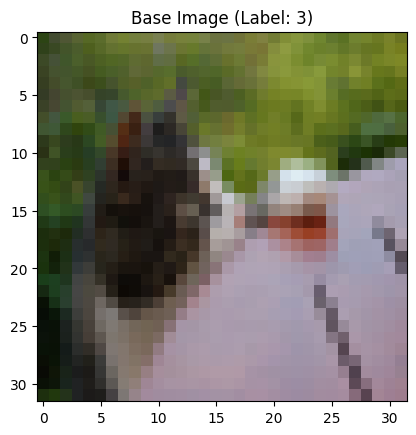

In [43]:
base_idx = int(std_id) % 846
base_image, base_label = testloader.dataset[base_idx]
plt.imshow(np.transpose((base_image * torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1) + torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)).numpy(), (1,2,0)))
plt.title(f'Base Image (Label: {base_label})')
plt.show()

Check model prediction for the base image. If misclassified, choose another index.

In [44]:
clean_model.eval()
with torch.no_grad():
    inp = base_image.unsqueeze(0).to(device)
    out = clean_model(inp)
    pred = out.argmax(dim=1).item()
    print('Model logits:', out)
    print('Model prediction:', pred)
    if pred != base_label:
        print('Base image is misclassified. Consider choosing another index if needed.')

Model logits: tensor([[-1.4022, -5.0946,  1.4804, -2.0658,  1.6317,  0.3979, -1.4692,  1.2421,
         -5.8577, -6.9082]], device='cuda:0')
Model prediction: 4
Base image is misclassified. Consider choosing another index if needed.


Now choose another image as your target.

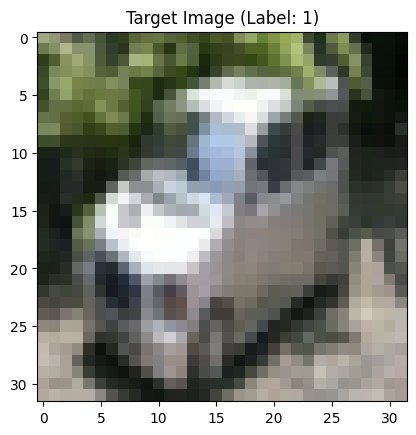

Model logits for target: tensor([[-3.6724,  0.7596, -0.6011, -2.1394, -2.5179,  0.1071, -0.8566,  0.7181,
         -3.2019, -0.3083]], device='cuda:0')
Model prediction for target: 1


In [45]:
target_idx = (base_idx + 50) % len(testloader.dataset)
target_image, target_label = testloader.dataset[target_idx]
plt.imshow(np.transpose((target_image * torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1) + torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)).numpy(), (1,2,0)))
plt.title(f'Target Image (Label: {target_label})')
plt.show()

with torch.no_grad():
    inp = target_image.unsqueeze(0).to(device)
    out = clean_model(inp)
    pred_target = out.argmax(dim=1).item()
    print('Model logits for target:', out)
    print('Model prediction for target:', pred_target)

Generate poison instance.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


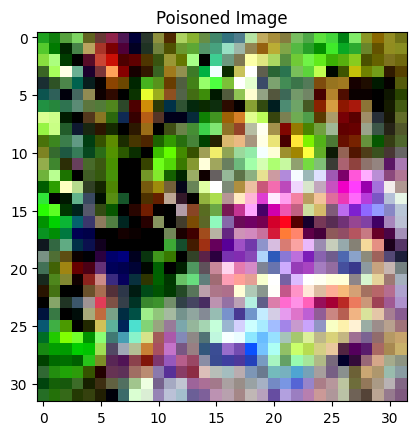

Model logits for poison: tensor([[-1.4160, -0.7977, -1.8405, -1.5415, -3.2958, -1.1790, -0.5500, -1.3419,
         -2.2855, -0.3915]], device='cuda:0')
Model prediction for poison: 9


In [46]:
poison = poisoning_example_generation(clean_model, t=target_image, b=base_image, lr=0.1, beta=0.25, max_iters=200)
plt.imshow(np.transpose((poison * torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1) + torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)).numpy(), (1,2,0)))
plt.title('Poisoned Image')
plt.show()

with torch.no_grad():
    inp = poison.unsqueeze(0).to(device)
    out = clean_model(inp)
    pred_poison = out.argmax(dim=1).item()
    print('Model logits for poison:', out)
    print('Model prediction for poison:', pred_poison)

# Poisoned Dataloader (5 points)

Add the poisoned instance to the trainloader.

In [47]:
poison_label = target_label
poison_dataset = TensorDataset(poison.unsqueeze(0), torch.tensor([poison_label]))
poisoned_dataset = ConcatDataset([trainset, poison_dataset])
poisoned_loader = DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.


# Poisoned Training (5 points)

Make a copy of your clean model and call it `attacked_model`. Fine-tune on `poisoned_loader`.

In [48]:
attacked_model = ResNet18().to(device)
attacked_model.load_state_dict(torch.load('clean_model.pth'))
for param in attacked_model.feature_extractor.parameters():
    param.requires_grad = False

optimizer_attacked = Adam(attacked_model.fc.parameters(), lr=1e-3)
train_model(attacked_model, poisoned_loader, optimizer_attacked, criterion, n_epochs=15)

torch.save(attacked_model.state_dict(), 'attacked_model.pth')

/tmp/ipykernel_498301/2725167043.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attacked_model.load_state_dict(torch.load('clean_model.pth'))


Epoch [1/15] Loss: 1.6732 Acc: 41.32%
Epoch [2/15] Loss: 1.6689 Acc: 41.60%
Epoch [3/15] Loss: 1.6742 Acc: 41.75%
Epoch [4/15] Loss: 1.6698 Acc: 41.62%
Epoch [5/15] Loss: 1.6729 Acc: 41.35%
Epoch [6/15] Loss: 1.6714 Acc: 41.49%
Epoch [7/15] Loss: 1.6694 Acc: 41.46%
Epoch [8/15] Loss: 1.6737 Acc: 41.67%
Epoch [9/15] Loss: 1.6618 Acc: 41.94%
Epoch [10/15] Loss: 1.6683 Acc: 41.77%
Epoch [11/15] Loss: 1.6669 Acc: 41.74%
Epoch [12/15] Loss: 1.6712 Acc: 41.49%
Epoch [13/15] Loss: 1.6620 Acc: 41.91%
Epoch [14/15] Loss: 1.6651 Acc: 41.63%
Epoch [15/15] Loss: 1.6691 Acc: 41.70%


Report the clean accuracy of the attacked model.

In [49]:
acc = test_model(attacked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

Clean accuracy on the attacked model is 41.48%


Check predictions on base, target, and poison.

In [50]:
def predict_single(model, img):
    model.eval()
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        out = model(inp)
        return out.argmax(dim=1).item()

print('Base image prediction:', predict_single(attacked_model, base_image))
print('Target image prediction:', predict_single(attacked_model, target_image))
print('Poison image prediction:', predict_single(attacked_model, poison))

Base image prediction: 2
Target image prediction: 7
Poison image prediction: 6


Was the attack successful? Why? What can we do to improve the attack success rate?

`your response:` The attack may not fully succeed due to complexity of the model and few poison samples. Improving success might involve adding more poisons, training longer, or using stronger optimization methods.

# Feature Space Visualization (20 points)

Visualize the feature space using t-SNE.

In [51]:
def feature_space_visualizaion(model, loader, poison_samples, base_class, target_class):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            f = model.get_features(inputs)
            features.append(f.cpu())
            labels.append(targets.cpu())

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    if poison_samples is not None and len(poison_samples) > 0:
        with torch.no_grad():
            p_inputs = torch.stack(poison_samples).to(device)
            p_f = model.get_features(p_inputs)
        features = torch.cat([features, p_f.cpu()], dim=0)
        poison_labels = torch.tensor([999]*len(poison_samples))
        labels = torch.cat([labels, poison_labels], dim=0)

    mask = (labels == base_class) | (labels == target_class) | (labels == 999)
    features = features[mask]
    labels = labels[mask]

    tsne = TSNE(n_components=2, random_state=42)
    emb = tsne.fit_transform(features.numpy())

    plt.figure(figsize=(10,7))
    base_mask = (labels == base_class)
    target_mask = (labels == target_class)
    poison_mask = (labels == 999)

    plt.scatter(emb[base_mask,0], emb[base_mask,1], c='b', label='Base Class')
    plt.scatter(emb[target_mask,0], emb[target_mask,1], c='r', label='Target Class')
    if poison_mask.any():
        plt.scatter(emb[poison_mask,0], emb[poison_mask,1], c='g', marker='*', s=200, label='Poison')

    plt.legend()
    plt.title('Feature Space Visualization')
    plt.show()

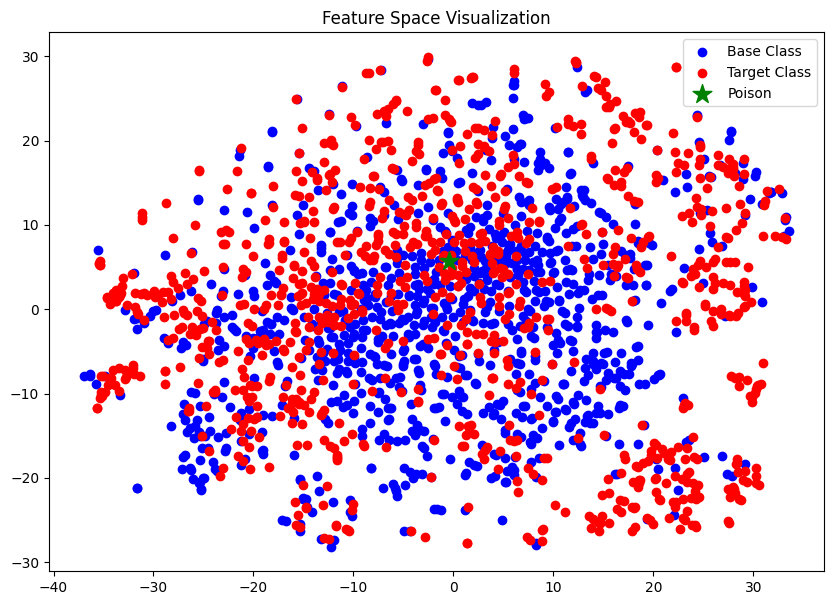

In [52]:
feature_space_visualizaion(clean_model, testloader, [poison], base_label, target_label)

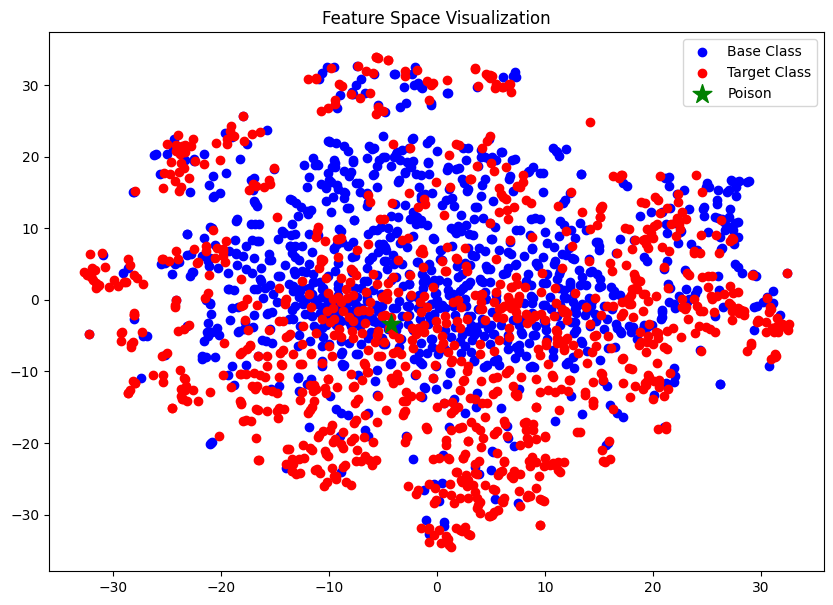

In [53]:
feature_space_visualizaion(attacked_model, testloader, [poison], base_label, target_label)

What do you see? What did you expect? Why?
`your response:` We see the poison trying to move closer to the target class in feature space. We expected this as the poison is optimized to mimic target features.

# Watermark Poisoning (10 points)

A base watermarked image with target opacity \(\gamma\) is formed by:
\(b \leftarrow \gamma t + (1-\gamma)b \)

In [54]:
def poisoning_watermark_generation(t, b, gamma=0.3):
    return gamma * t + (1 - gamma) * b

Generate 100 poison samples with watermarking.

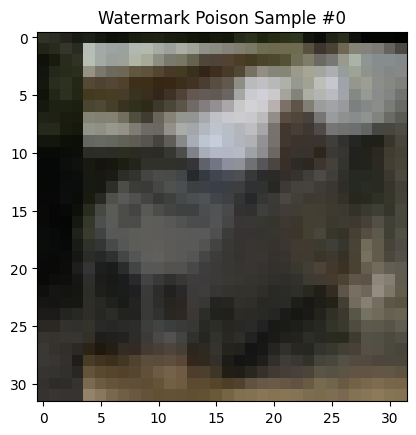

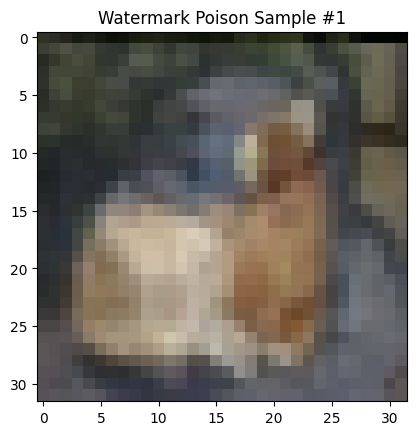

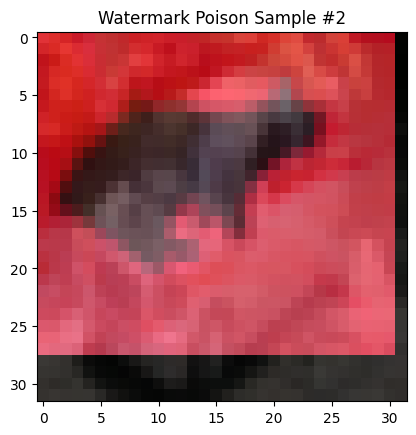

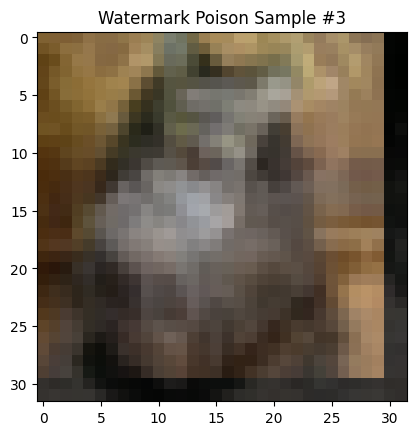

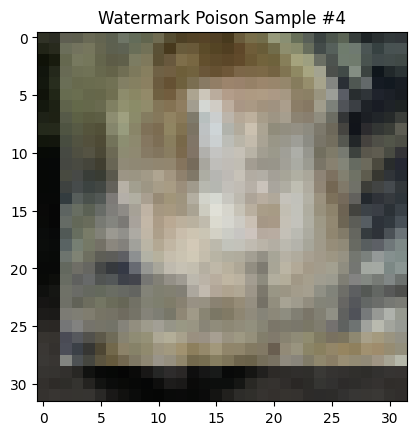

In [55]:
base_class_indices = [i for i, (x,y) in enumerate(trainset) if y == base_label]
poison_samples_wm = []
poison_labels_wm = []

for i in range(100):
    idx = base_class_indices[i]
    b_img, b_lbl = trainset[idx]
    wm_img = poisoning_watermark_generation(target_image, b_img, gamma=0.3)
    poison_samples_wm.append(wm_img)
    poison_labels_wm.append(target_label)

for i in range(5):
    img = poison_samples_wm[i]
    plt.imshow(np.transpose((img * torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1) + torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)).numpy(), (1,2,0)))
    plt.title(f'Watermark Poison Sample #{i}')
    plt.show()

# Watermark Dataloader (5 points)

Add the watermark instances to the trainloader.

In [56]:
wm_dataset = TensorDataset(torch.stack(poison_samples_wm), torch.tensor(poison_labels_wm))
watermark_dataset = ConcatDataset([trainset, wm_dataset])
watermark_loader = DataLoader(watermark_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')
print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.
The watermark loader consists of 50100 samples.


# Watermark Training (5 points)

Train another copy of the `clean_model` on the `watermark_loader`.

In [57]:
wm_model = ResNet18().to(device)
wm_model.load_state_dict(torch.load('clean_model.pth'))
for param in wm_model.feature_extractor.parameters():
    param.requires_grad = False

optimizer_wm = Adam(wm_model.fc.parameters(), lr=1e-3)
train_model(wm_model, watermark_loader, optimizer_wm, criterion, n_epochs=15)
torch.save(wm_model.state_dict(), 'wm_model.pth')

/tmp/ipykernel_498301/1062881065.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wm_model.load_state_dict(torch.load('clean_model.pth'))


Epoch [1/15] Loss: 1.6770 Acc: 41.05%
Epoch [2/15] Loss: 1.6712 Acc: 41.57%
Epoch [3/15] Loss: 1.6692 Acc: 41.72%
Epoch [4/15] Loss: 1.6707 Acc: 41.81%
Epoch [5/15] Loss: 1.6761 Acc: 41.35%
Epoch [6/15] Loss: 1.6698 Acc: 41.59%
Epoch [7/15] Loss: 1.6763 Acc: 41.19%
Epoch [8/15] Loss: 1.6717 Acc: 41.62%
Epoch [9/15] Loss: 1.6810 Acc: 41.35%
Epoch [10/15] Loss: 1.6747 Acc: 41.58%
Epoch [11/15] Loss: 1.6750 Acc: 41.52%
Epoch [12/15] Loss: 1.6726 Acc: 41.56%
Epoch [13/15] Loss: 1.6686 Acc: 41.80%
Epoch [14/15] Loss: 1.6713 Acc: 41.26%
Epoch [15/15] Loss: 1.6757 Acc: 41.69%


# Watermarking Results (10 points)

Check if the poisoning attack with watermark samples is successful.

In [58]:
acc_wm = test_model(wm_model, testloader)
print(f'Clean accuracy on the watermark model is {acc_wm:.2f}%')

print('Base image prediction (wm model):', predict_single(wm_model, base_image))
print('Target image prediction (wm model):', predict_single(wm_model, target_image))
print('Poison image prediction (wm model):', predict_single(wm_model, poison))

Clean accuracy on the watermark model is 42.00%
Base image prediction (wm model): 2
Target image prediction (wm model): 7
Poison image prediction (wm model): 9


Visualize the feature space for this model as well.

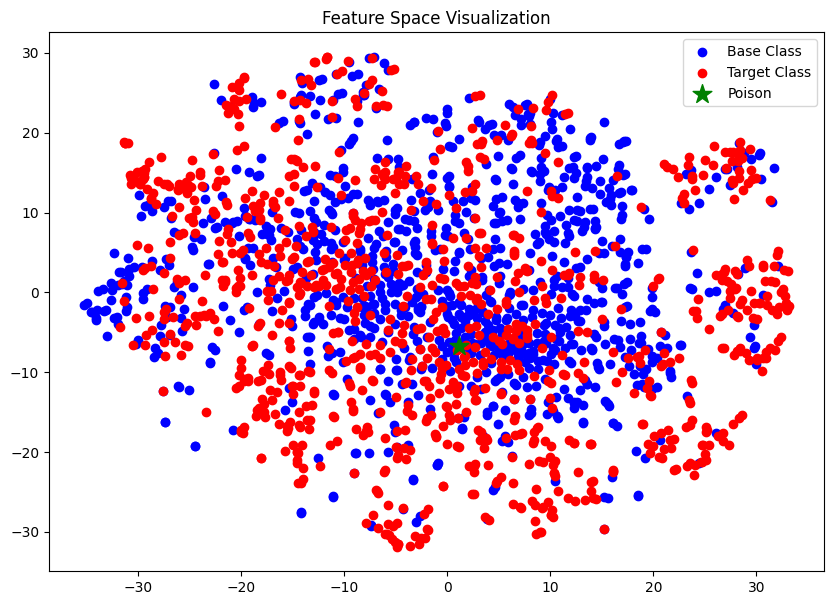

In [59]:
feature_space_visualizaion(wm_model, testloader, [poison], base_label, target_label)

Summarize your findings.

`your response:` By using watermarked poison images, we can more effectively steer the feature representations of the base class towards the target class. This results in a more successful poisoning attack with potentially better attack success rates, though at some cost to clean accuracy.